# Spinal Orientation Classification
### CS 398 - Deep Learning: Programming Assignment 2
---
### Author
> [Eric Zander](https://github.com/ericzander)

### Description
> A [TensorFlow](https://www.tensorflow.org/) class project in which an ANN and CNN were built to identify the orientation of axial spinal cord images. Hyperband parameter tuning was performed with [Keras Tuner](https://keras.io/keras_tuner/). The results and formatting of this notebook were altered slightly following the actual submission, which achieved first place with an accuracy of **99.875%** on the 4000 test images.

### Table of Contents
* [Setup](#c0)
* [a) Load Data](#c1)
* [b) ANN](#c2)
* [c) CNN](#c3)
* [d) Performance Comparison](#c4)
* [Make Predictions](#c5)

---

# Setup <a name="c0"></a>

In [61]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras_tuner as kt

In [63]:
# Verify if any GPUs are available and supported
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# a) Load Data <a name="c1"></a>

##### Load Data

In [64]:
def read_training_data(path):
    images = []  # List of image data
    labels = []  # List of orientation labels

    # For every directory in directory (including root)
    for root, dirs, files in os.walk(path):
        # Skip root directory
        if root != path:
            # Save label for path (0, 1, 2, and 3) from end of directory name
            label = root[-1]

            # Load each file and save the image data and its label
            for file in files:
                images.append(plt.imread(os.path.join(root, file)))
                labels.append(int(label))
                
    # Convert to numpy arrays and return
    return np.array(images), np.array(labels)

In [65]:
images, labels = read_training_data("SpinalScans16images/train")

##### Check Data

In [66]:
# Print data shapes
print(f"Images Shape : {images.shape}")
print(f"Labels Shape : {labels.shape}")
print(f"Classes      : {np.unique(labels)}")

# Save shape of inputs and number of orientations
input_shape = (224, 224, 1)
num_classes = len(np.unique(labels))

Images Shape : (16000, 224, 224)
Labels Shape : (16000,)
Classes      : [0 1 2 3]


##### Vis

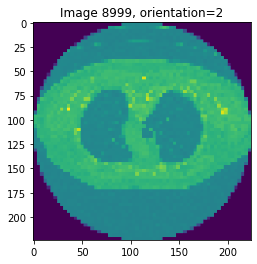

In [67]:
# Select image index
image_no = 8999

# Visualize image
plt.imshow(images[image_no])
plt.title(f"Image {image_no}, orientation={labels[image_no]}")
plt.show()

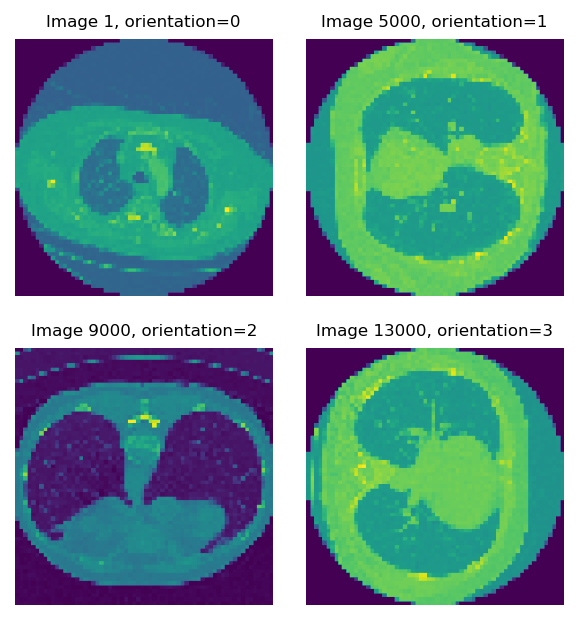

In [72]:
inds = [1, 5000, 9000, 13000]

fig, axes = plt.subplots(2, 2, dpi=150, figsize=(5, 5))
for i, ax in enumerate(axes.reshape(-1)):
    image_no = inds[i]
    ax.imshow(images[image_no])
    ax.set_title(f"Image {image_no}, orientation={labels[image_no]}", fontsize=8)
    ax.axis("off")
    
plt.subplots_adjust(wspace=0.001)
plt.show()

##### Split Data (75:25)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25)

In [9]:
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_test shape  : {y_test.shape}")

X_train shape : (12000, 224, 224)
X_test shape  : (4000, 224, 224)
y_train shape : (12000,)
y_test shape  : (4000,)


##### One-Hot Encoding

In [10]:
# One hot encode training labels
y_train = keras.utils.to_categorical(y_train, num_classes)
y_train.shape

(12000, 4)

In [11]:
# One hot encode testing labels
y_test = keras.utils.to_categorical(y_test, num_classes)
y_test.shape

(4000, 4)

##### Other Setup

In [12]:
# Create test accuracy dictionary
accuracy = dict()

# b) ANN <a name="c2"></a>

> Create a network with no convolutional layers. Minimal tuning is done due to likely outperformance by CNN.

##### Note

> Hyperband parameter tuning is used to select the network's hyperparameters. This can take some time and requires the Keras Tuner package.

* Keras Tuner:
    * https://www.tensorflow.org/tutorials/keras/keras_tuner
* Hyperband Framework:
    * https://arxiv.org/pdf/1603.06560.pdf

##### Run Hyperband Parameter Tuning

In [13]:
def ann_builder(hp):
    """
    Creates a model with variable hyperparameters to be tested and optimized with
    the Hyperband framework accessible through the Keras Tuner.
    """
    # Create model
    ann = keras.Sequential()
    ann.add(keras.Input(shape=input_shape))
    
    # Add max pooling
    ann.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten
    ann.add(layers.Flatten())
    
    # Add two dense layers with a variable number of neurons
    d1 = hp.Int(f"d1", min_value=32, max_value=512, step=32)
    d2 = hp.Int(f"d2", min_value=32, max_value=512, step=32)
    
    # Add softmax output layer
    ann.add(layers.Dense(num_classes, activation="softmax"))
    
    # Compile model
    ann.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return ann

In [14]:
# Create tuner
tuner = kt.Hyperband(
    ann_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    project_name="ANN-search",
    overwrite=True,
    executions_per_trial=3,
)

In [15]:
%%time

# Search for best hyperparameters (may take a while)
tuner.search(X_train, y_train, epochs=50, validation_split=0.1)

Trial 30 Complete [00h 00m 28s]
val_accuracy: 0.971666673819224

Best val_accuracy So Far: 0.971666673819224
Total elapsed time: 00h 06m 40s
INFO:tensorflow:Oracle triggered exit
CPU times: total: 12min 31s
Wall time: 6min 39s


In [16]:
# Save best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)
best_hps

##### Display Results

In [17]:
# Save best dense layer sizes
d1 = best_hps[0].get("d1")
d2 = best_hps[0].get("d2")

print(f'd1: {d1}')
print(f'd2: {d2}')

d1: 320
d2: 352


##### Create Model

In [18]:
# Create model with best parameters
ann = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(d1, activation="relu"),  # Submission: 192
        layers.Dense(d2, activation="relu"),  # Submission: 224
        layers.Dense(num_classes, activation="softmax"),
    ]
)

ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 1)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_1 (Dense)             (None, 320)               4014400   
                                                                 
 dense_2 (Dense)             (None, 352)               112992    
                                                                 
 dense_3 (Dense)             (None, 4)                 1412      
                                                                 
Total params: 4,128,804
Trainable params: 4,128,804
Non-trainable params: 0
____________________________________________

##### Fit and Test Model

In [19]:
# Set fitting parameters
batch_size = 128
epochs = 100

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

# Compile and fit
ann.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
        callbacks=[stop_early])

Epoch 1/100
85/85 [==============================] - 1s 9ms/step - loss: 1.2435 - accuracy: 0.7118 - val_loss: 0.3046 - val_accuracy: 0.8917
Epoch 2/100
85/85 [==============================] - 1s 7ms/step - loss: 0.2598 - accuracy: 0.9054 - val_loss: 0.2143 - val_accuracy: 0.9242
Epoch 3/100
85/85 [==============================] - 1s 7ms/step - loss: 0.1974 - accuracy: 0.9291 - val_loss: 0.1847 - val_accuracy: 0.9333
Epoch 4/100
85/85 [==============================] - 1s 7ms/step - loss: 0.1429 - accuracy: 0.9494 - val_loss: 0.1350 - val_accuracy: 0.9525
Epoch 5/100
85/85 [==============================] - 1s 7ms/step - loss: 0.1970 - accuracy: 0.9251 - val_loss: 0.2338 - val_accuracy: 0.9058
Epoch 6/100
85/85 [==============================] - 1s 7ms/step - loss: 0.1534 - accuracy: 0.9435 - val_loss: 0.1159 - val_accuracy: 0.9533
Epoch 7/100
85/85 [==============================] - 1s 6ms/step - loss: 0.0990 - accuracy: 0.9648 - val_loss: 0.1413 - val_accuracy: 0.9458
Epoch 8/100
8

Epoch 59/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0491 - val_accuracy: 0.9850
Epoch 60/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0187 - accuracy: 0.9935 - val_loss: 0.0514 - val_accuracy: 0.9867
Epoch 61/100
85/85 [==============================] - 1s 6ms/step - loss: 0.0168 - accuracy: 0.9938 - val_loss: 0.0552 - val_accuracy: 0.9883
Epoch 62/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0278 - accuracy: 0.9895 - val_loss: 0.0655 - val_accuracy: 0.9842
Epoch 63/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.1378 - val_accuracy: 0.9567
Epoch 64/100
85/85 [==============================] - 1s 6ms/step - loss: 0.0343 - accuracy: 0.9884 - val_loss: 0.1231 - val_accuracy: 0.9658
Epoch 65/100
85/85 [==============================] - 1s 7ms/step - loss: 0.0395 - accuracy: 0.9862 - val_loss: 0.0833 - val_accuracy: 0.9742
Epoch 

In [20]:
# Evaluate on test data
loss, accuracy["ann"] = ann.evaluate(X_test, y_test)  # Submission acc: 0.9787
print(f"Accuracy: {accuracy['ann'] * 100:.4f}%")

125/125 [==============================] - 0s 2ms/step - loss: 0.0506 - accuracy: 0.9847
Accuracy: 98.4750%


# c) CNN <a name="c3"></a>

> Creating a simple CNN with one convolutional layer.

##### Note

> See (b) for description and citations for Hyperband parameter tuning.

##### Run Hyperband Parameter Tuning

In [21]:
def cnn_builder(hp):
    """
    Creates a model with variable hyperparameters to be tested and optimized with
    the Hyperband framework accessible through the Keras Tuner.
    
    Creates a model with one convolutional layer.
    """
    # Create model
    cnn = keras.Sequential()
    cnn.add(keras.Input(shape=input_shape))
    
    # Create convolutional layer with variable number of filters and kernel size
    filters = hp.Int("filters", min_value=16, max_value=128, step=16)
    ks = hp.Int(f"ks", min_value=3, max_value=5, step=1)
    cnn.add(layers.Conv2D(filters, kernel_size=(ks, ks), activation="relu"))
    
    # Add max pooling
    cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten
    cnn.add(layers.Flatten())
    
    # Add two dense layers with variable number of neurons
    d1, d2 = [hp.Int(f"d{i + 1}", min_value=32, max_value=512, step=32) for i in range(2)]
    
    # Add softmax output layer
    cnn.add(layers.Dense(num_classes, activation="softmax"))
    
    # Compile model
    cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return cnn

In [22]:
# Create hyperparameter tuner
# Each bracket has ceil(log_3(max_epochs)) models
tuner = kt.Hyperband(
    cnn_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    project_name="CNN-search",
    overwrite=True,
    executions_per_trial=3,
)

# Create callback to cut searches short with high validation
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [23]:
%%time

# Search for best hyperparameters (may take a while)
tuner.search(X_train, y_train, epochs=50, batch_size=128,
             validation_split=0.1)

Trial 30 Complete [00h 02m 23s]
val_accuracy: 0.9975000023841858

Best val_accuracy So Far: 0.9975000023841858
Total elapsed time: 00h 27m 25s
INFO:tensorflow:Oracle triggered exit
CPU times: total: 32min 8s
Wall time: 27min 25s


In [24]:
# Save best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)
best_hps

##### Display Results

In [25]:
# Save best parameters
filters = best_hps[0].get("filters")
ks = best_hps[0].get("ks")
d1 = best_hps[0].get("d1")
d2 = best_hps[0].get("d2")

print(f'filters: {filters}')
print(f'ks: {ks}')
print(f'd1: {d1}')
print(f'd2: {d2}')

filters: 112
ks: 5
d1: 160
d2: 128


##### Create Model

In [26]:
# Create model with best parameters
cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(filters, kernel_size=(ks, ks), activation="relu"),  # Submission: 64, 4x4
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(d1, activation="relu"),  # Submission: 128
        layers.Dense(d2, activation="relu"),  # Submission: 480
        layers.Dense(num_classes, activation="softmax"),
    ]
)

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 112)     2912      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 112)    0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1355200)           0         
                                                                 
 dense_1 (Dense)             (None, 160)               216832160 
                                                                 
 dense_2 (Dense)             (None, 128)               20608     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                      

##### Test Model

In [27]:
# Set fitting parameters
batch_size = 64
epochs = 50

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Compile and fit
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
        callbacks=[stop_early])

Epoch 1/50
169/169 [==============================] - 8s 48ms/step - loss: 1.2245 - accuracy: 0.8293 - val_loss: 0.0617 - val_accuracy: 0.9842
Epoch 2/50
169/169 [==============================] - 8s 47ms/step - loss: 0.0203 - accuracy: 0.9958 - val_loss: 0.0256 - val_accuracy: 0.9950
Epoch 3/50
169/169 [==============================] - 8s 47ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.0138 - val_accuracy: 0.9967
Epoch 4/50
169/169 [==============================] - 8s 47ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0122 - val_accuracy: 0.9967
Epoch 5/50
169/169 [==============================] - 8s 47ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0114 - val_accuracy: 0.9958
Epoch 6/50
169/169 [==============================] - 8s 47ms/step - loss: 5.4688e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9975
Epoch 7/50
169/169 [==============================] - 8s 47ms/step - loss: 2.6317e-04 - accuracy: 1.0000 - val_loss: 0.0104 - val_accuracy

In [28]:
loss, accuracy["cnn"] = cnn.evaluate(X_test, y_test)  # Submission: 0.99775%
print(f"Accuracy: {accuracy['cnn'] * 100:.4f}%")

125/125 [==============================] - 1s 10ms/step - loss: 0.0056 - accuracy: 0.9985
Accuracy: 99.8500%


# d) Performance Comparison <a name="c4"></a>

> The performance between the ANN and CNN are compared. Additional resources were spent tuning the CNN given it's likely ability to outperform the ANN, so it must be noted that this may skew results.

CNN Accuracy: 99.8500%
ANN Accuracy: 98.4750%


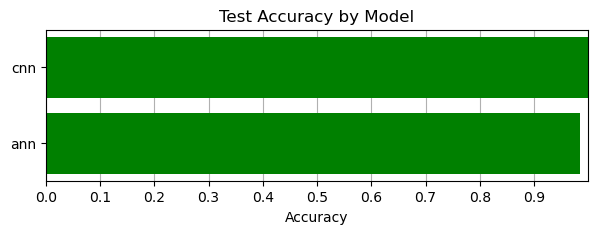

In [29]:
print(f"CNN Accuracy: {accuracy['cnn'] * 100:.4f}%")
print(f"ANN Accuracy: {accuracy['ann'] * 100:.4f}%")

plt.figure(figsize=(7, 2), dpi=100)
plt.barh(list(accuracy.keys()), list(accuracy.values()), height=0.8, color="green")
plt.title("Test Accuracy by Model")
plt.xlabel("Accuracy")
plt.xlim(0, 1)
plt.xticks(np.arange(0, 1, 0.1))
plt.gca().set_axisbelow(True)
plt.grid(which="major", axis="x")
plt.show()

> The convolutional layer clearly affords improvement of the already performant ANN. While it is possible that experimentation with different architectures or other steps such as data augmentation could afford better results, it is difficult to improve on a test accuracy of about 99.8%.

# Make Predictions <a name="c5"></a>

> With the best discovered CNN architecture, final predictions are made and formatted for submission.

#### Load Test Data

In [30]:
def read_testing_data(path):
    images = []   # List of image data
    indices = []  # Indices of images

    # For every directory in directory (including root)
    for root, dirs, files in os.walk(path):
        # Load each file and save the image data and its label
        for file in files:
            images.append(plt.imread(os.path.join(root, file)))
            indices.append(file.split(".")[0])
                
    # Convert to numpy arrays and return
    return np.array(images), np.array(indices)
    
images, indices = read_testing_data("test_4K_images/test")

In [31]:
images.shape

(4000, 224, 224)

In [32]:
indices.shape

(4000,)

#### Predict Labels

In [33]:
# Create predictions using CNN
pred = cnn.predict(images)
pred

125/125 [==============================] - 1s 9ms/step


array([[6.5794397e-06, 9.1584837e-01, 3.8559738e-04, 8.3759435e-02],
       [1.2592871e-21, 1.0773037e-18, 1.0000000e+00, 1.0712760e-17],
       [2.9255412e-07, 1.3780513e-08, 9.9999964e-01, 7.4783119e-10],
       ...,
       [1.8164602e-11, 1.4505658e-08, 5.0199461e-10, 1.0000000e+00],
       [2.2618763e-11, 1.0000000e+00, 5.8543723e-08, 2.2610481e-11],
       [2.0143835e-09, 2.8677913e-10, 1.6065987e-06, 9.9999845e-01]],
      dtype=float32)

In [34]:
pred.shape

(4000, 4)

In [35]:
# Collapse to single column
pred = np.argmax(pred, axis=1)
pred

array([1, 2, 2, ..., 3, 1, 3], dtype=int64)

In [36]:
pred.shape

(4000,)

#### Write Predictions to .csv

In [37]:
# Write predictions to file (commented out for submission)
output = pd.DataFrame({"indices": indices, "predictions": pred})
#output.to_csv("Assignment2_4KPredictions_Eric_Zander.csv", header=False, index=False)